In [117]:
# IMPORTS
import os
import numpy as np
import cv2
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
import skimage.io as io
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix


### Read Dataset


In [3]:
def read_images(folder_path, labels=False):
    '''
     Read images from a folder and return them as a list of numpy arrays.
     Normalize the images
    '''
    images = []
    file_names = os.listdir(folder_path)
    for file_name in file_names:
        image = io.imread(os.path.join(folder_path, file_name))
        if not labels:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)

    return images


# read dataset
A = read_images('dataset/trainval/A')  # initial images
B = read_images('dataset/trainval/B')  # images after a certain amount of time
# ground truth images (actual change)
labels = read_images('dataset/trainval/label', labels=True)

assert len(A) == len(B) == len(
    labels), "Number of images in A, B and labels are not equal."

In [4]:
# Split dataset into training, validation and test sets
A_train, A_test, B_train, B_test, labels_train, labels_test = train_test_split(
    A, B, labels, test_size=0.3, random_state=42)

# we can use the same function to split the training set into training and validation sets
# A_train, A_val, B_train, B_val, labels_train, labels_val = train_test_split(A_train, B_train, labels_train, test_size=0.2, random_state=42)

## Research findings: <br>

1. I think the most appropriate approach given the dataset is ab Object-Based Chnage Detection (By adopting an object-based approach, you can achieve more accurate and meaningful results for change detection in complex landscapes such as desert areas, where pixel-based methods may be less effective due to spatial heterogeneity and spectral variability.) and since our dataset is detecting change in desert areas, specifically buildings.
2. For image prerpcessing: first step is to apply radiometric normalization to remove the atmospheric effect and any noise


Random index:  25
Random image before change


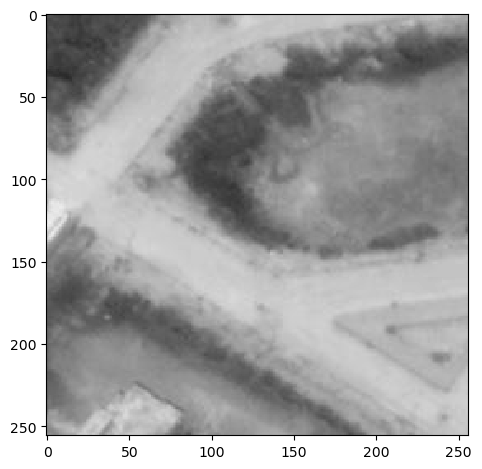

Random image after change


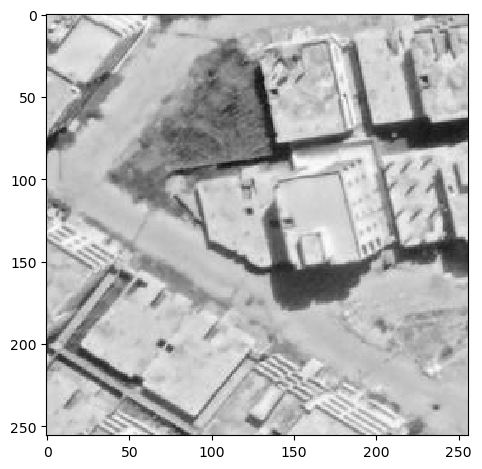

Change ground truth of the random image


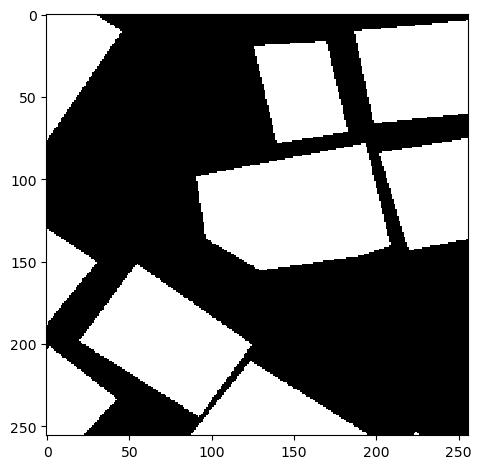

In [5]:
# 427 => white line

# Show first image in the training set
# np.random.seed(968652)
# random_index = np.random.randint(0, len(A_train))
# random_index = 21
random_index = 25
print("Random index: ", random_index)
print("Random image before change")
io.imshow(A_train[random_index])
io.show()

print("Random image after change")
io.imshow(B_train[random_index])
io.show()

print("Change ground truth of the random image")
io.imshow(labels_train[random_index])
io.show()

In [133]:
def get_mask_naive(img_A, img_B, verbose=False):

    # equalize histograms
    gray_image_A = cv2.equalizeHist(img_A)
    gray_image_B = cv2.equalizeHist(img_B)

    # gaussian blur
    gray_image_A = cv2.GaussianBlur(gray_image_A, (17, 17), 0)
    gray_image_B = cv2.GaussianBlur(gray_image_B, (17, 17), 0)

    # Compute the absolute difference between the two images
    difference_image = cv2.absdiff(gray_image_A, gray_image_B)
    
    # show the difference image
    if verbose:
        io.imshow(difference_image)
        io.show()

    thresh = cv2.adaptiveThreshold(
        difference_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91, 11)
    
    

    # histogram equalization
    if verbose:
        io.imshow(thresh)
        io.show()
        
    # invert 
    # thresh = cv2.bitwise_not(thresh)
    return thresh

print(get_mask_with_contours(A_train[random_index], B_train[random_index], ))

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


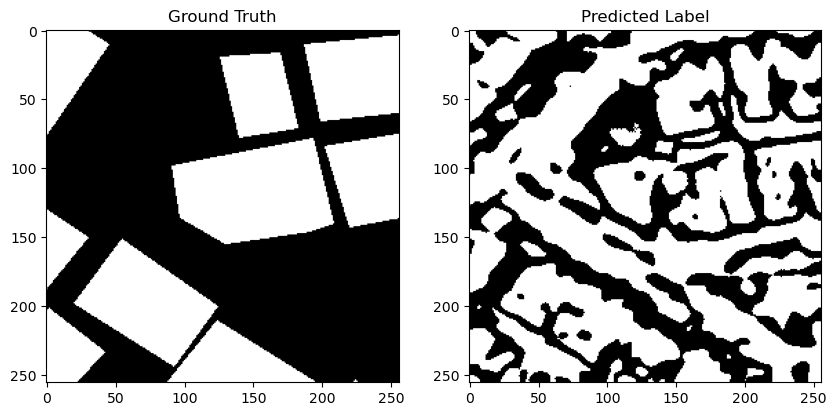

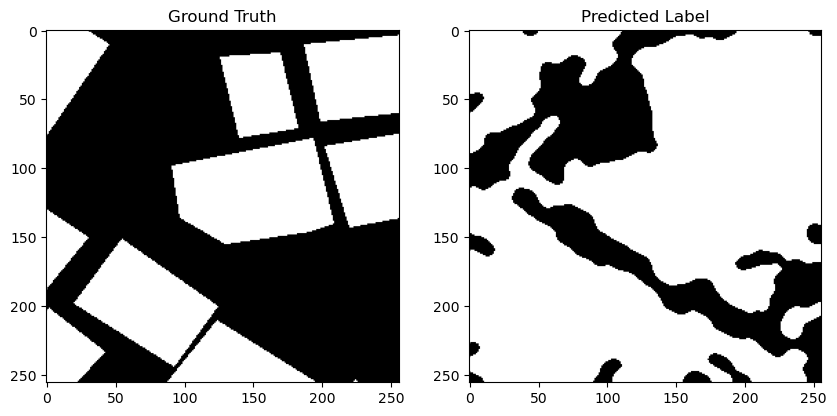

In [132]:
def get_mask_with_contours(img_A, img_B, verbose = False):
    
    # equalize histograms
    gray_image_A = cv2.equalizeHist(img_A)
    gray_image_B = cv2.equalizeHist(img_B)

    # gaussian blur
    gray_image_A = cv2.GaussianBlur(gray_image_A, (25, 25), 1.5)
    gray_image_B = cv2.GaussianBlur(gray_image_B, (25, 25), 1.5)

    # Compute the absolute difference between the two images
    difference_image = cv2.absdiff(gray_image_A, gray_image_B)
    
    #invert
    difference_image = cv2.bitwise_not(
        difference_image
    )
    
    
    # show the difference image
    if verbose:
        io.imshow(difference_image)
        io.show()


    # edge detection using Canny
    edges = cv2.Canny(difference_image, 100, 200,L2gradient=True)
    if verbose:
        io.imshow(edges)
        io.show()




    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)
    if verbose:
        io.imshow(closed_edges)
        io.show()
    closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_DILATE, kernel, iterations=1)
    if verbose:
        io.imshow(closed_edges)
        io.show()
    # filter
    closed_edges = cv2.medianBlur(closed_edges, 5)
    closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_CLOSE, kernel, iterations=3)
    closed_edges = cv2.medianBlur(closed_edges, 5)
    if verbose:
        io.imshow(closed_edges)
        io.show()
    closed_edges = cv2.morphologyEx(closed_edges, cv2.MORPH_DILATE, kernel, iterations=1)
    closed_edges = cv2.medianBlur(closed_edges, 5)
    if verbose:
    # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)
    # closed_edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel, iterations=1)
        io.imshow(closed_edges)
        io.show()



    # find countours
    contours, _ = cv2.findContours(
        closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    img_copy = np.ones((256, 256), dtype=np.uint8)

    cv2.drawContours(img_copy, contours, -1, (255), thickness=cv2.FILLED)
    if verbose:
        print("Contours")
        io.imshow(img_copy)
        io.show()

    img_copy = cv2.normalize(img_copy, None, 0, 255, cv2.NORM_MINMAX)
    return img_copy

# io.imshow(get_mask_with_contours(A_train[random_index], B_train[random_index], ))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(labels_train[random_index], cmap="gray")
ax[0].set_title('Ground Truth')
ax[1].imshow(get_mask_naive(A_train[random_index], B_train[random_index], ), cmap="gray")
ax[1].set_title('Predicted Label')
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(labels_train[random_index], cmap="gray")
ax[0].set_title('Ground Truth')
ax[1].imshow(get_mask_with_contours(A_train[random_index], B_train[random_index], ), cmap="gray")
ax[1].set_title('Predicted Label')
plt.show()



In [23]:
def check_var_diff(img_A, img_B):
    '''
    Check if the standard deviation of the two images is different
    '''
    # convert images to int
    img_A = img_A.astype(np.int32)
    img_B = img_B.astype(np.int32)
    
    var_A = np.var(img_A)
    var_B = np.var(img_B)
    
    return np.abs(var_A - var_B) / (var_A + var_B)

In [24]:
def check_change(label, threshold = 0.02):
    '''
    Check if more than the threshold is white pixels
    '''
    # normalize the image
    label = cv2.normalize(label, None, 0, 255, cv2.NORM_MINMAX)
    white_pixels = np.sum(label == 255)
    total_pixels = label.shape[0] * label.shape[1]
    return white_pixels / total_pixels > threshold

In [25]:
def radiometric_correction(img):
    '''
    Radiometric correction of an image
    '''
    # Convert to floating point for radiometric correction
    image_float = img.astype(np.float32)

    # Radiometric correction (e.g., flat field correction, atmospheric correction)
    # Example: Subtract mean and divide by standard deviation
    mean = np.mean(image_float)
    std_dev = np.std(image_float)
    corrected_image = (image_float - mean) / std_dev

    # Normalize the corrected image to [0, 255]
    normalized_image = cv2.normalize(
        corrected_image, None, 0, 255, cv2.NORM_MINMAX)

    # Convert back to uint8 format
    normalized_image = np.uint8(normalized_image)

    return normalized_image
    

In [50]:
# we need to plot a histogram of the variance differences between images depending on whether there's a change or not
# loop through the images, get the std_diff between each a and b image, check if the ground truth has more than 98% black pixels,
# if it does, then there's no change, else there's a change
# if there's a change, append the variance difference to the change list, else append to the no change list

change_list = []
no_change_list = []
for i in range(len(A_train)):
    
    std_diff = check_var_diff(A_train[i], B_train[i])
    if check_change(labels_train[i]):
        change_list.append(std_diff)
    else:
        no_change_list.append(std_diff)



In [106]:
def compute_jaccard_score(img_A, img_B, micro=False):
    '''
    Compute the jacard score between two images
    '''
    # noramlize
    img_A = cv2.normalize(img_A, None, 0, 255, cv2.NORM_MINMAX)
    img_B = cv2.normalize(img_B, None, 0, 255, cv2.NORM_MINMAX)

    img_A = img_A.astype('int32')
    img_B = img_B.astype('int32')

    j_score = 0
    if micro:
        # compute the jacard score
        j_score = jaccard_score(img_A.flatten(), img_B.flatten(
        ), average="micro",  zero_division=1)

    else:
        # compute the jacard score
        j_score = jaccard_score(img_A.flatten(), img_B.flatten(
        ), average="binary", pos_label=255, zero_division=1)
    return j_score

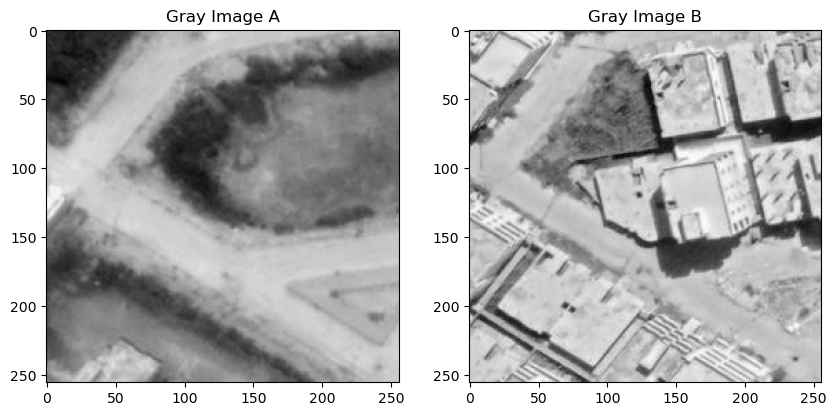

In [78]:
# plot grat_img_A and b side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(A_train[random_index], cmap="gray")
ax[0].set_title('Gray Image A')
ax[1].imshow(B_train[random_index], cmap="gray")
ax[1].set_title('Gray Image B')
plt.show()
# print()

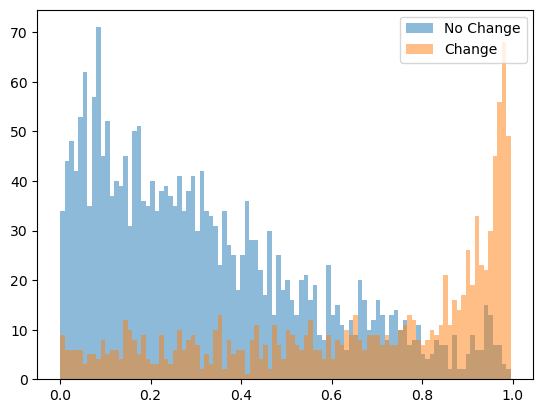

In [80]:
        
# plot the histogram
plt.hist(no_change_list, bins=100, alpha=0.5, label='No Change')
plt.hist(change_list, bins=100, alpha=0.5, label='Change')
plt.legend(loc='upper right')
plt.show()

In [51]:
# get mean of change and no change
mean_change = np.mean(change_list)
mean_no_change = np.mean(no_change_list)
print("Mean of change: ", mean_change)
print("Mean of no change: ", mean_no_change)

# std
std_change = np.std(change_list)
std_no_change = np.std(no_change_list)
print("Standard deviation of change: ", std_change)
print("Standard deviation of no change: ", std_no_change)

Mean of change:  0.6653459606257811
Mean of no change:  0.3223525913256606
Standard deviation of change:  0.30379375800970493
Standard deviation of no change:  0.2432603152016336


In [62]:

jaccard_change_list = []
jaccard_no_change_list = []
for i in tqdm(range(len(A_train))):
    
    jacard_score = compute_jaccard_score(A_train[i], B_train[i])
    if check_change(labels_train[i]):
        jaccard_change_list.append(jacard_score)
    else:
        jaccard_no_change_list.append(jacard_score)
        

100%|██████████| 3407/3407 [02:10<00:00, 26.06it/s]


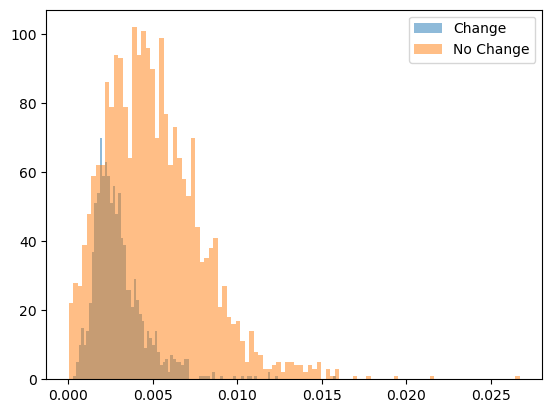

In [63]:
        
# plot the histogram
plt.hist(jaccard_change_list, bins=100, alpha=0.5, label='Change')
plt.hist(jaccard_no_change_list, bins=100, alpha=0.5, label='No Change')
plt.legend(loc='upper right')
plt.show()

In [64]:
# get mean of change and no change
j_mean_change = np.mean(jaccard_change_list)
j_mean_no_change = np.mean(jaccard_no_change_list)
print("Mean of change: ", j_mean_change)
print("Mean of no change: ", j_mean_no_change)
#var
j_var_change = np.var(jaccard_change_list)
j_var_no_change = np.var(jaccard_no_change_list)
print("Variance of change: ", j_var_change)
print("Variance of no change: ", j_var_no_change)
# std
j_std_change = np.std(jaccard_change_list)
j_std_no_change = np.std(jaccard_no_change_list)
print("Standard deviation of change: ", j_std_change)
print("Standard deviation of no change: ", j_std_no_change)

Mean of change:  0.0029946981595743373
Mean of no change:  0.005028815107373611
Variance of change:  2.565248396796743e-06
Variance of no change:  8.266446621518049e-06
Standard deviation of change:  0.0016016392842324839
Standard deviation of no change:  0.002875142887148054


In [120]:
def eval_scores(predicted, labels, title):

    # for training set
    predicted = np.array(predicted)
    predicted = predicted.flatten()
    labels = np.array(labels)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        labels.flatten(), predicted, average='binary', pos_label=255)
    print(f"{title} Precision: ", precision)
    print(f"{title} Recall: ", recall)
    print(f"{title} F1 Score: ", f1_score)

## Naive image differencing

In [108]:
# for training dataset
# we need to check for each image from a and b if there's a change
# based on the above statistics, if the variance difference between the 2 images is within the no change range
# then there's no change, else there's a change
# if there's no change, out mask will be a black image
# if there's a change, we will get the mask of the change
# then we need to compute the jaccard index between the mask and the label
# compute the average score for all the dataset
# if there's no change, the jaccard will be 1


naive_all_jaccard = []
naive_all_jaccard_micro = []
naive_predicted_masks = []
# for each image in the training set
for i in tqdm(range(len(A_train))):
    change_mask = get_mask_naive(
        radiometric_correction(A_train[i]), radiometric_correction(B_train[i]))
    naive_predicted_masks.append(change_mask)
    j_score = compute_jaccard_score(change_mask, labels_train[i])
    naive_all_jaccard.append(j_score)
    naive_all_jaccard_micro.append(compute_jaccard_score(
        change_mask, labels_train[i], micro=True))

naive_test_all_jaccard = []
naive_test_all_jaccard_micro = []
naive_test_predicted_masks = []
# for each image in the testing set
for i in tqdm(range(len(A_test))):

    change_mask = get_mask_naive(
        radiometric_correction(A_test[i]), radiometric_correction(B_test[i]))
    naive_test_predicted_masks.append(change_mask)
    j_score = compute_jaccard_score(change_mask, labels_test[i])
    naive_test_all_jaccard.append(j_score)
    naive_test_all_jaccard_micro.append(compute_jaccard_score(
        change_mask, labels_test[i], micro=True))

# compute the average jaccard score
naive_average_jaccard = np.mean(naive_all_jaccard)
print("Average Naive Training Jaccard score: ", naive_average_jaccard)
naive_average_jaccard_micro = np.mean(naive_all_jaccard_micro)
print("Average Naive Training Jaccard score (Mirco): ", naive_average_jaccard_micro)

test_average_jaccard = np.mean(naive_test_all_jaccard)
print("Average Naive Training Jaccard score: ", test_average_jaccard)
test_average_jaccard_micro = np.mean(naive_test_all_jaccard_micro)
print("Average Naive Training Jaccard score (Mirco): ", test_average_jaccard_micro)

# write predictions and lables
# for training set
for i in range(len(naive_predicted_masks)):
    cv2.imwrite(
        f"dataset/predictions/train/naive/predicted/{i}.png", naive_predicted_masks[i])
    cv2.imwrite(
        f"dataset/predictions/train/naive/ground_truth/{i}.png", labels_train[i])

# for testing set
for i in range(len(naive_test_predicted_masks)):
    cv2.imwrite(
        f"dataset/predictions/test/naive/predicted/{i}.png", naive_test_predicted_masks[i])
    cv2.imwrite(
        f"dataset/predictions/test/naive/ground_truth/{i}.png", labels_test[i])

100%|██████████| 1461/1461 [00:44<00:00, 33.09it/s]


Average Naive Training Jaccard score:  0.0566144263830597
Average Naive Training Jaccard score (Mirco):  0.2748639345893097
Average Naive raining Jaccard score:  0.05475528049212442
Average Naive Training Jaccard score (Mirco):  0.27465859602562265


In [121]:
# calculate precision, recall, f1 score and confusion matrix 
# for training set
eval_scores(
    naive_predicted_masks, labels_train, "Naive Training")

# for testing set
eval_scores(
    naive_test_predicted_masks, labels_test, "Naive Testing")

Naive Training Precision:  0.06854079753503084
Naive Training Recall:  0.5739711914051757
Naive Training F1 Score:  0.12245823859546279
Naive Testing Precision:  0.06692855660002106
Naive Testing Recall:  0.5766055888498542
Naive Testing F1 Score:  0.11993576428566312


### With contours and no change check


In [134]:
# for training dataset
# we need to check for each image from a and b if there's a change
# based on the above statistics, if the variance difference between the 2 images is within the no change range
# then there's no change, else there's a change
# if there's no change, out mask will be a black image
# if there's a change, we will get the mask of the change
# then we need to compute the jaccard index between the mask and the label
# compute the average score for all the dataset
# if there's no change, the jaccard will be 1


all_jaccard = []
all_jaccard_micro = []
predicted_masks = []
# for each image in the training set
for i in tqdm(range(len(A_train))):
    change_mask = get_mask_with_contours(
        radiometric_correction(A_train[i]), radiometric_correction(B_train[i]))
    predicted_masks.append(change_mask)
    j_score = compute_jaccard_score(change_mask, labels_train[i])
    all_jaccard.append(j_score)
    all_jaccard_micro.append(compute_jaccard_score(change_mask, labels_train[i], micro=True))

test_all_jaccard = []
test_all_jaccard_micro = []
test_predicted_masks = []
# for each image in the testing set
for i in tqdm(range(len(A_test))):

    change_mask = get_mask_with_contours(
        radiometric_correction(A_test[i]), radiometric_correction(B_test[i]))
    test_predicted_masks.append(change_mask)
    j_score = compute_jaccard_score(change_mask, labels_test[i])
    test_all_jaccard.append(j_score)
    test_all_jaccard_micro.append(compute_jaccard_score(change_mask, labels_test[i], micro=True))

# compute the average jaccard score
average_jaccard = np.mean(all_jaccard)
print("Average Training Jaccard score: ", average_jaccard)
average_jaccard_micro = np.mean(all_jaccard_micro)
print("Average Training Jaccard score (Mirco): ", average_jaccard_micro)
test_average_jaccard = np.mean(test_all_jaccard)
print("Average Testing Jaccard score: ", test_average_jaccard)
test_average_jaccard_micro = np.mean(test_all_jaccard_micro)
print("Average Testing Jaccard score (Mirco): ", test_average_jaccard_micro)

# write predictions and lables 
# for training set
for i in range(len(predicted_masks)):
    cv2.imwrite(f"dataset/predictions/train/contours/predicted/{i}.png", predicted_masks[i])
    cv2.imwrite(f"dataset/predictions/train/contours/ground_truth/{i}.png", labels_train[i])
    
# for testing set
for i in range(len(test_predicted_masks)):
    cv2.imwrite(f"dataset/predictions/test/contours/predicted/{i}.png", test_predicted_masks[i])
    cv2.imwrite(f"dataset/predictions/test/contours/ground_truth/{i}.png", labels_test[i])

100%|██████████| 1461/1461 [01:01<00:00, 23.66it/s]


Average Training Jaccard score:  0.077899928018772
Average Training Jaccard score (Mirco):  0.11760529995895343
Average Testing Jaccard score:  0.07712041088987175
Average Testing Jaccard score (Mirco):  0.11392299738586845


In [137]:
# evaluate scores
# calculate precision, recall, f1 score and confusion matrix
# for training set
eval_scores(predicted_masks, labels_train, "Training")

# for testing set
eval_scores(test_predicted_masks, labels_test, "Testing")


Training Precision:  0.07393218120467993
Training Recall:  0.9314487809025648
Training F1 Score:  0.13699093706375726
Testing Precision:  0.07153538303778188
Testing Recall:  0.9324715291857263
Testing F1 Score:  0.13287698959044136


In [139]:
# for training dataset
# we need to check for each image from a and b if there's a change
# based on the above statistics, if the variance difference between the 2 images is within the no change range
# then there's no change, else there's a change
# if there's no change, out mask will be a black image
# if there's a change, we will get the mask of the change
# then we need to compute the jaccard index between the mask and the label
# compute the average score for all the dataset
# if there's no change, the jaccard will be 1



# test
final_all_jaccard = []
final_all_jaccard_micro = []
final_predicted_masks = []
final_change_count = 0
final_no_change_count = 0
# for each image in the testing set
for i in tqdm(range(len(A_train))):
    # get the variance difference
    var_diff = check_var_diff(A_train[i], B_train[i])

    # check if there's a change
    if mean_change - std_change <= var_diff <= mean_change + std_change:
        change_mask = get_mask_with_contours(
            radiometric_correction(A_train[i]), radiometric_correction(B_train[i]))
        final_predicted_masks.append(change_mask)
        j_score = compute_jaccard_score(change_mask, labels_train[i])
        final_all_jaccard.append(j_score)
        final_all_jaccard_micro.append(compute_jaccard_score(change_mask, labels_train[i], micro=True))
        final_change_count += 1

    else:
        final_no_change_count += 1
        final_all_jaccard.append(1)
        final_all_jaccard_micro.append(1)
        final_predicted_masks.append(
            np.zeros((256, 256), dtype=np.uint8))

final_test_all_jaccard = []
final_test_all_jaccard_micro = []
final_test_predicted_masks = []
final_test_change_count = 0
final_test_no_change_count = 0
# for each image in the testing set
for i in tqdm(range(len(A_test))):
    # get the variance difference
    var_diff = check_var_diff(A_test[i], B_test[i])

    # check if there's a change
    if mean_change - std_change <= var_diff <= mean_change + std_change:
        change_mask = get_mask_with_contours(
            radiometric_correction(A_test[i]), radiometric_correction(B_test[i]))
        final_test_predicted_masks.append(change_mask)
        j_score = compute_jaccard_score(change_mask, labels_test[i])
        final_test_all_jaccard.append(j_score)
        final_test_all_jaccard_micro.append(compute_jaccard_score(change_mask, labels_test[i], micro=True))
        final_test_change_count += 1

    else:
        final_test_no_change_count += 1
        final_test_all_jaccard.append(1)
        final_test_all_jaccard_micro.append(1)
        
        final_test_predicted_masks.append(
            np.zeros((256, 256), dtype=np.uint8))

# compute the average jaccard score
final_average_jaccard = np.mean(final_all_jaccard)
print("Average Training Jaccard score: ", final_average_jaccard)

final_average_jaccard_micro = np.mean(final_all_jaccard_micro)
print("Average Training Jaccard score (Mirco): ", final_average_jaccard_micro)

final_test_average_jaccard = np.mean(final_test_all_jaccard)
print("Average Testing Jaccard score: ", final_test_average_jaccard)

final_test_average_jaccard_micro = np.mean(final_test_all_jaccard_micro)
print("Average Testing Jaccard score (Mirco): ", final_test_average_jaccard_micro)
# write predictions and lables 
# for training set
for i in range(len(predicted_masks)):
    cv2.imwrite(f"dataset/predictions/train/contours_final/predicted/{i}.png", final_predicted_masks[i])
    cv2.imwrite(f"dataset/predictions/train/contours_final/ground_truth/{i}.png", labels_train[i])
    
# for testing set
for i in range(len(test_predicted_masks)):
    cv2.imwrite(f"dataset/predictions/test/contours_final/predicted/{i}.png", final_test_predicted_masks[i])
    cv2.imwrite(f"dataset/predictions/test/contours_final/ground_truth/{i}.png", labels_test[i])

100%|██████████| 1461/1461 [00:27<00:00, 53.49it/s]


Average Training Jaccard score:  0.6007731302788898
Average Training Jaccard score (Mirco):  0.6161994820963168
Average Testing Jaccard score:  0.6235095052586799
Average Testing Jaccard score (Mirco):  0.6375307467577529


In [140]:
# eval scores
# calculate precision, recall, f1 score and confusion matrix
# for training set
eval_scores(final_predicted_masks, labels_train, "Training")

# for testing set
eval_scores(final_test_predicted_masks, labels_test, "Testing")

Training Precision:  0.10744005638094388
Training Recall:  0.596995186661333
Training F1 Score:  0.1821067220800487
Testing Precision:  0.11376122677327863
Testing Recall:  0.6160833803425247
Testing F1 Score:  0.19205842026938075


In [141]:
########### EVALUTATION DATASET ########### 
eval_A = read_images("./dataset/test/A")
eval_B = read_images("./dataset/test/B")


In [147]:

# ########### EVALUTATION DATASET ########### 

eval_predicted_masks = []
eval_change_count = 0
eval_no_change_count = 0
# for each image in the testing set
for i in tqdm(range(len(eval_A))):
    # get the variance difference
    var_diff = check_var_diff(eval_A[i], eval_B[i])

    # check if there's a change
    if mean_change - std_change <= var_diff <= mean_change + std_change:
        change_mask = get_mask_with_contours(
            radiometric_correction(eval_A[i]), radiometric_correction(eval_B[i]))
        eval_predicted_masks.append(change_mask)
        eval_change_count += 1

    else:
        eval_no_change_count += 1
        eval_predicted_masks.append(
            np.zeros((256, 256), dtype=np.uint8))

# write predictions and lables 
# for training set
for i in range(len(eval_predicted_masks)):
    cv2.imwrite(f"dataset/evaluation/{i}.png", eval_predicted_masks[i])
 

100%|██████████| 608/608 [00:04<00:00, 122.97it/s]


In [148]:
eval_change_count

438